# Data Cleaning
Not dealing with NaNs just yet

In [1]:
# The libraries needed

import pandas as pd
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv("phl_exoplanet_catalog_2019.csv")

In [3]:
df.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


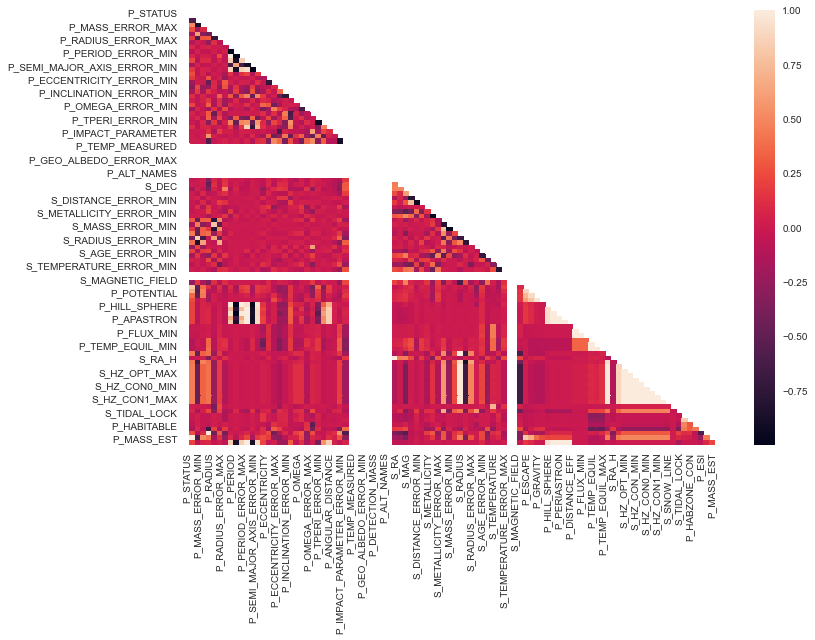

In [4]:
# The heatmap shows high correlation in the DF

plt.figure(figsize=(12, 8))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), mask=mask)
plt.show()

In [5]:
# removing irrelevant columns
df.drop(columns=["P_NAME", "P_STATUS", "P_YEAR", "P_UPDATED", "P_ALT_NAMES", "S_NAME", "S_ALT_NAMES", "S_CONSTELLATION", "S_CONSTELLATION_ABR", "S_CONSTELLATION_ENG", "S_TYPE_TEMP"], inplace=True)

# removing error columns
df.drop(columns=[i for i in list(df.columns) if i.endswith("ERROR_MIN")==True or i.endswith("ERROR_MAX")==True], inplace=True)

# removing columns with no or only 1 values
df.drop(columns=["P_TEMP_MEASURED", "P_GEO_ALBEDO", "P_DETECTION_MASS", "P_DETECTION_RADIUS", "P_ATMOSPHERE", "S_DISC", "S_MAGNETIC_FIELD"], inplace=True)

# removing columns to similar to the target var in order to combat multicollinearity
df.drop(columns=["P_ESI", "P_HABZONE_OPT", "P_HABZONE_CON", 'S_HZ_OPT_MIN', 'S_HZ_OPT_MAX', 'S_HZ_CON_MIN','S_HZ_CON_MAX', 'S_HZ_CON0_MIN', 'S_HZ_CON0_MAX', 'S_HZ_CON1_MIN','S_HZ_CON1_MAX', 'S_ABIO_ZONE', "P_MASS_EST", "P_RADIUS_EST", "P_HILL_SPHERE", "P_PERIASTRON", "P_SEMI_MAJOR_AXIS_EST", "P_SEMI_MAJOR_AXIS", "P_APASTRON", "P_DISTANCE_EFF", "S_RA_H", "S_RADIUS_EST", "S_SNOW_LINE", "S_LUMINOSITY", "P_POTENTIAL", "P_FLUX_MIN", "P_FLUX_MAX", "P_TEMP_EQUIL_MIN", "P_TEMP_EQUIL_MAX", "S_RA_H", "P_GRAVITY"], inplace=True)

# this row contains a negative number for star age
df.drop(4043, inplace=True)
df.drop(4044, inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# making our target variable binary:
df.P_HABITABLE = df.P_HABITABLE.map({2:1, 1:1, 0:0})

# DAE

## Adding a column for star similarity to our sun

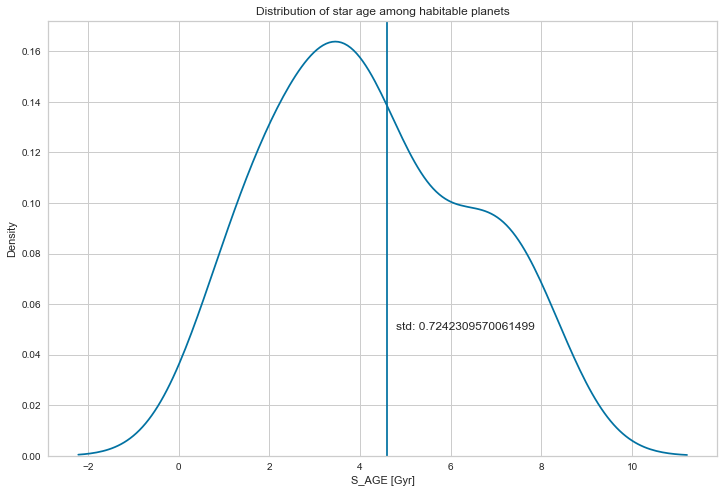

In [7]:
# The plots below shows the distribution of certain magnitudes as well as our own sun's values

plt.figure(figsize=(12, 8))
plt.axvline(4.6, 0,1)
plt.text(4.8,0.05,f'std: {4.6/(df.loc[df.P_HABITABLE == 1].S_AGE.std()+df.loc[df.P_HABITABLE == 1].S_AGE.mean())}',rotation=0)
sns.kdeplot(data=df.loc[df.P_HABITABLE == 1], x="S_AGE")
plt.title("Distribution of star age among habitable planets")
plt.xlabel("S_AGE [Gyr]")
plt.show()

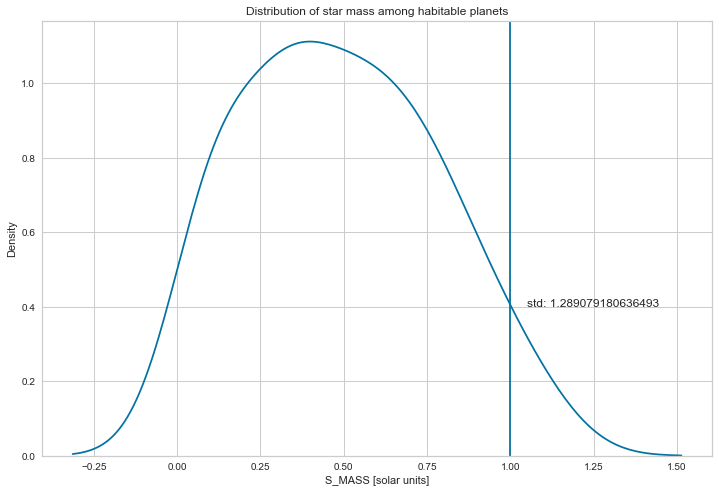

In [8]:
plt.figure(figsize=(12, 8))
plt.axvline(1, 0,1)
plt.text(1.05,0.4,f'std: {1/(df.loc[df.P_HABITABLE == 1].S_MASS.std()+df.loc[df.P_HABITABLE == 1].S_MASS.mean())}',rotation=0)
sns.kdeplot(data=df.loc[df.P_HABITABLE == 1], x="S_MASS")
plt.title("Distribution of star mass among habitable planets")
plt.xlabel("S_MASS [solar units]")
plt.show()

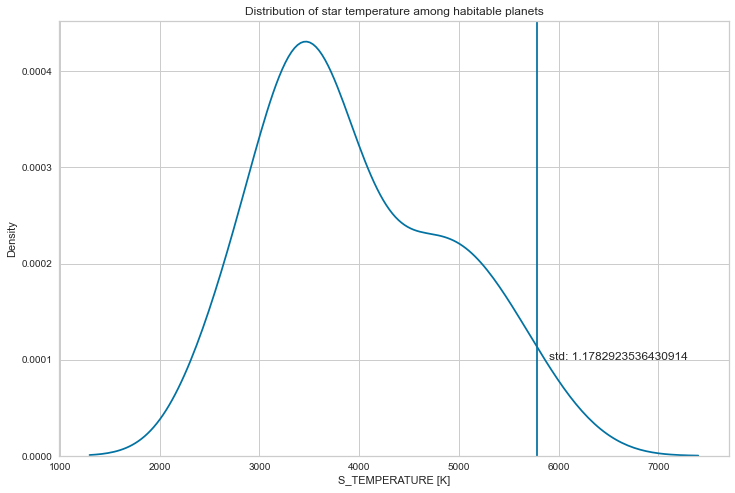

In [9]:
plt.figure(figsize=(12, 8))
plt.axvline(5778, 0,1)
plt.text(5900,0.0001,f'std: {5778/(df.loc[df.P_HABITABLE == 1].S_TEMPERATURE.std()+df.loc[df.P_HABITABLE == 1].S_TEMPERATURE.mean())}',rotation=0)
sns.kdeplot(data=df.loc[df.P_HABITABLE == 1], x="S_TEMPERATURE")
plt.title("Distribution of star temperature among habitable planets")
plt.xlabel("S_TEMPERATURE [K]")
plt.show()

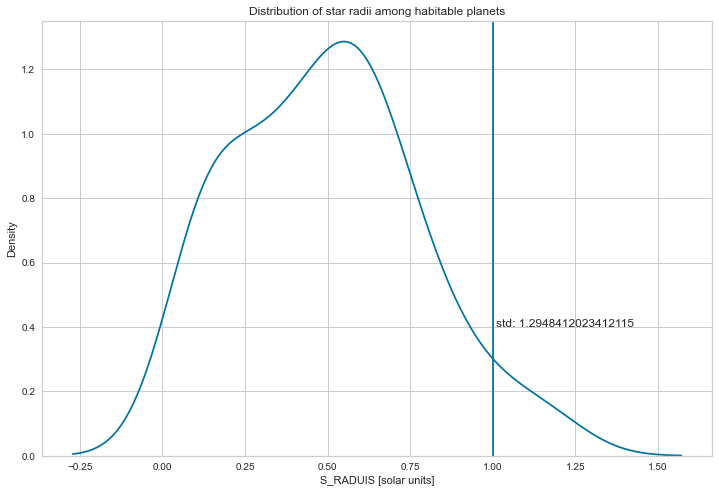

In [10]:
plt.figure(figsize=(12, 8))
plt.axvline(1, 0,1)
plt.text(1.01,0.4,f'std: {1/(df.loc[df.P_HABITABLE == 1].S_RADIUS.std()+df.loc[df.P_HABITABLE == 1].S_RADIUS.mean())}',rotation=0)
sns.kdeplot(data=df.loc[df.P_HABITABLE == 1], x="S_RADIUS")
plt.title("Distribution of star radii among habitable planets")
plt.xlabel("S_RADUIS [solar units]")
plt.show()

In [11]:
# Creating the "Sun Similarity Index"
df["S_SSI"] = np.sqrt((df.S_RADIUS - 1)**2) + np.sqrt((df.S_MASS - 1)**2) + np.sqrt((df.S_AGE - 4.6)**2) + np.sqrt((df.S_TEMPERATURE - 5778)**2)

# EDA

## PCA
In order to see if the habitable planets follow a certain distinct behaviour compared to the other data points

In [12]:
scaler = StandardScaler()
pca = PCA()

In [13]:
df_scale = scaler.fit_transform(df.drop(columns=list(df.select_dtypes("object").columns)).fillna(df.select_dtypes("number").mean()))

In [14]:
pca.fit_transform(df_scale)
print(pca.explained_variance_ratio_)

[0.11144645 0.08264646 0.07586398 0.06971887 0.05887605 0.05304159
 0.04735166 0.0431967  0.0397082  0.03768389 0.03731242 0.03631077
 0.03506394 0.03415575 0.03252603 0.02891774 0.02715159 0.02604572
 0.02263256 0.02121585 0.01965004 0.01592597 0.01300215 0.01074599
 0.00939685 0.00606026 0.00435248]


In [15]:
pc1=[]
pc2=[]
pc3=[]
for i in list(pca.fit_transform(df_scale)):
    pc1.append(i[0])
    pc2.append(i[1])
    pc3.append(i[1])

In [16]:
df["pc1"]=pc1
df["pc2"]=pc2
df["pc3"]=pc3

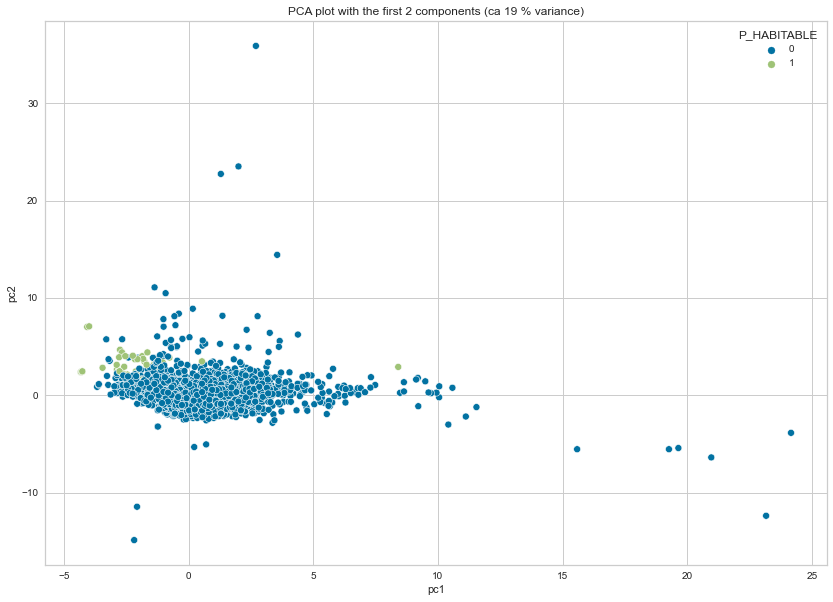

In [17]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df, x="pc1", y="pc2", hue="P_HABITABLE")
plt.title("PCA plot with the first 2 components (ca 19 % variance)")
plt.show()

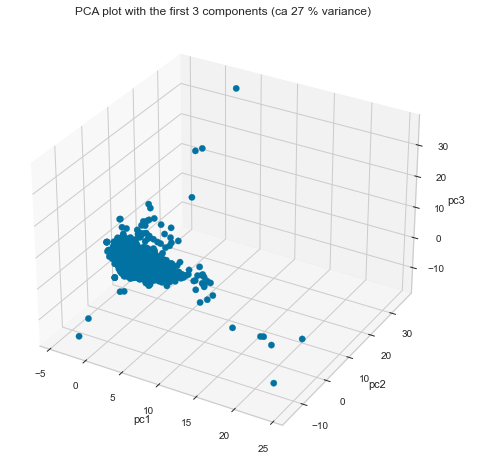

In [18]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df.pc1, df.pc2, df.pc3, s=40, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set_title("PCA plot with the first 3 components (ca 27 % variance)")

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [19]:
# Dropping the pca components as I don't want them to interfere with the ML model
df.drop(columns=["pc1", "pc2", "pc3"], inplace=True)

## Clusters

In order to see if unsupervised ML would cluster the habitable planets vs the inhabitable ones

In [20]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(df_scale)

KMeans(n_clusters=2)

In [21]:
df["clusters"] = kmeans.labels_

In [22]:
df.clusters.value_counts()

0    2815
1    1231
Name: clusters, dtype: int64

In [23]:
df.loc[df.clusters == 1].P_HABITABLE

0       0
1       0
2       0
3       0
4       0
       ..
4038    0
4039    0
4040    0
4041    0
4042    0
Name: P_HABITABLE, Length: 1231, dtype: int64

In [24]:
# dropping the clusters column as I don't want it to interfere with the ML model
df.drop(columns=["clusters"], inplace=True)

## Trying to identify characteristics of hab planets vs inhab planets

In [25]:
hab_means=list(df.loc[df.P_HABITABLE==1].describe().loc["mean"])

In [26]:
unhab_means = list(df.loc[df.P_HABITABLE==0].describe().loc["mean"])

In [27]:
# picking out the columns where the mean values of the inhab planets differs greatly from the hab planets
column_ind=[]
for i in range(len(hab_means)):
    try:
        if hab_means[i]/unhab_means[i] < 0.01 or hab_means[i]/unhab_means[i] > 1.99:
            column_ind.append(i)
    except:
        continue

In [28]:
column_of_note=[]

for i in column_ind:
    column_of_note.append(list(df.select_dtypes("number"))[i])
column_of_note

['P_MASS', 'S_METALLICITY', 'P_FLUX', 'S_SSI']

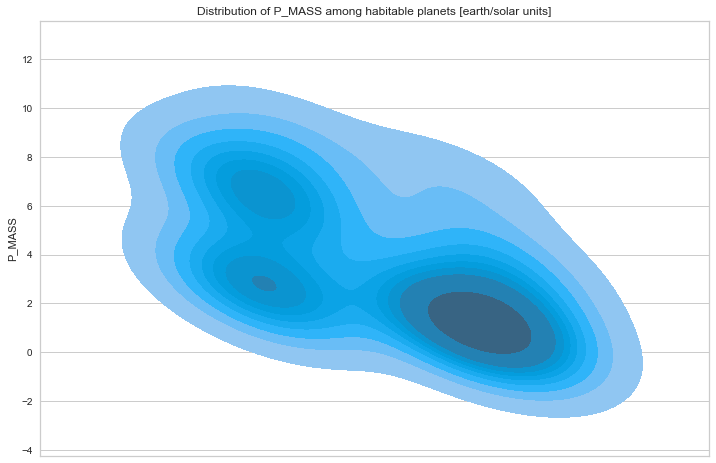

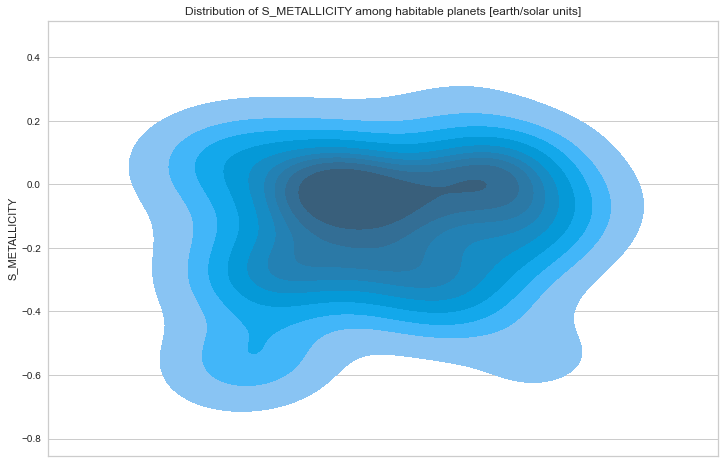

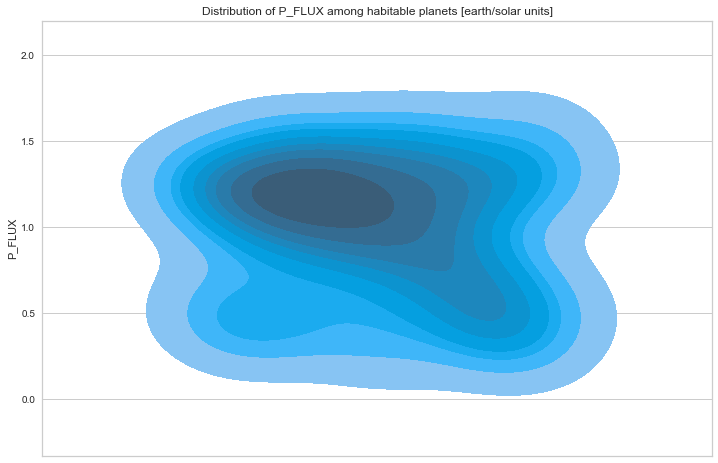

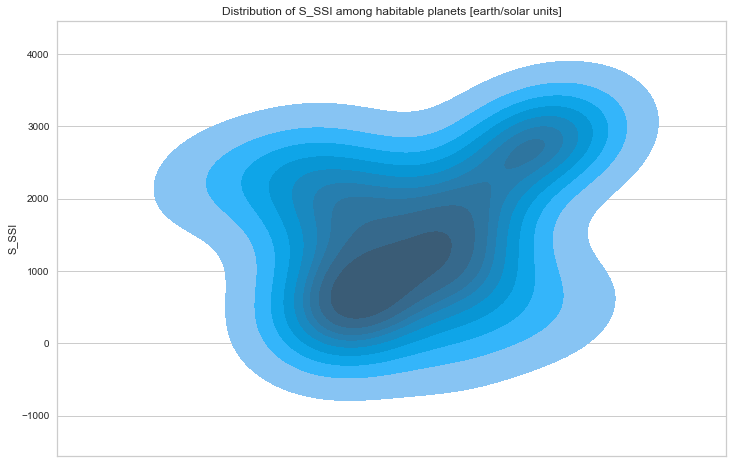

In [29]:
for i in column_of_note:
    plt.figure(figsize=(12, 8))
    a=sns.kdeplot(data=df.loc[df.P_HABITABLE == 1], y=i, x=df.loc[df.P_HABITABLE == 1].reset_index().index, shade=True)
    a.set(xticks=[])
    plt.title(f"Distribution of {i} among habitable planets [earth/solar units]")
    plt.show()

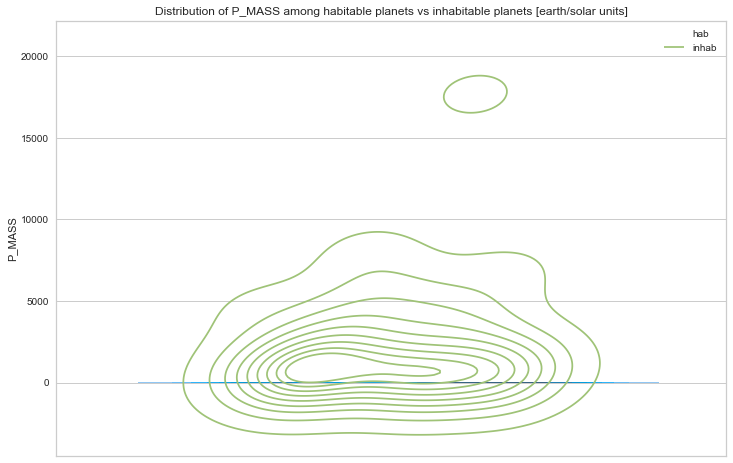

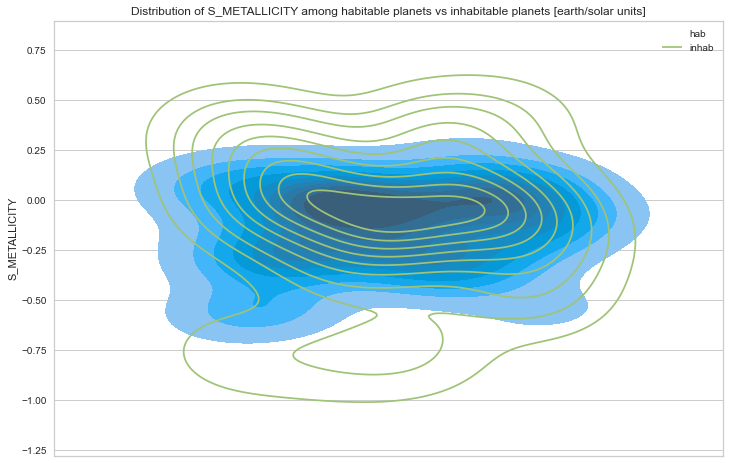

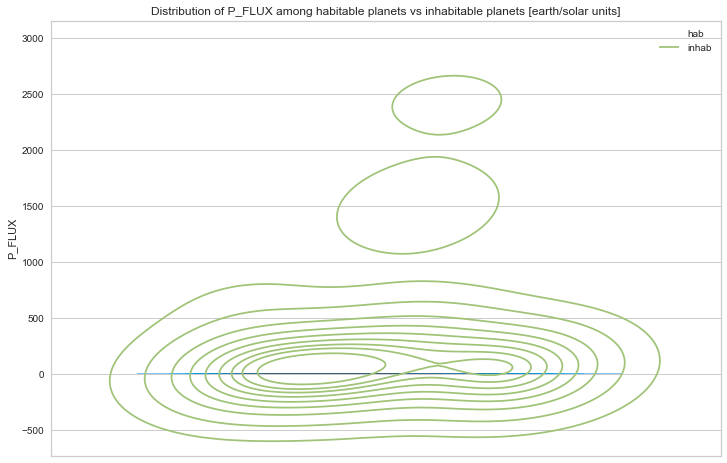

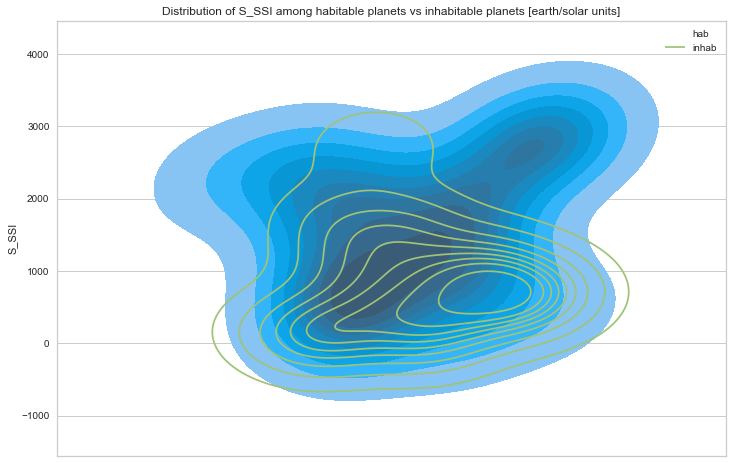

In [31]:
for i in column_of_note:
    plt.figure(figsize=(12, 8))
    a=sns.kdeplot(data=df.loc[df.P_HABITABLE == 1], y=i, x=df.loc[df.P_HABITABLE == 1].reset_index().index, shade=True,  label="hab")
    b=sns.kdeplot(data=df.loc[df.P_HABITABLE == 0].reset_index().loc[random.sample(range(0, len(df.loc[df.P_HABITABLE == 1])), len(df.loc[df.P_HABITABLE == 1]))], y=i, x=df.loc[df.P_HABITABLE == 0].reset_index().loc[random.sample(range(0, len(df.loc[df.P_HABITABLE == 1])), len(df.loc[df.P_HABITABLE == 1]))].reset_index().index, label="inhab")
    a.set(xticks=[])
    b.set(xticks=[])
    plt.title(f"Distribution of {i} among habitable planets vs inhabitable planets [earth/solar units]")
    plt.legend()
    plt.show()

# Target var: P_HABITABLE

## X & y

In [941]:
X = df.drop(columns = ["P_HABITABLE"])
y = df.P_HABITABLE

In [942]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Preprocessing with pipeline

In [944]:
num_trans = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_trans = make_pipeline(SimpleImputer(strategy = "constant", fill_value="missing"), OneHotEncoder(handle_unknown = "ignore"))

In [945]:
num_cols = X.select_dtypes("number").columns
cat_cols = X.select_dtypes("object").columns

In [946]:
preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## Model selector with scoring

In [948]:
classifiers=[RandomForestClassifier(), SVC(), LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), GaussianNB(), RidgeClassifier()]

In [949]:
kappa_scorer = make_scorer(cohen_kappa_score)
scorings = ["accuracy", "f1", "precision", "recall", kappa_scorer]

In [950]:
for i in classifiers:
    x=0
    for j in scorings:
        grid = GridSearchCV(i, cv=10, scoring = j, param_grid={})

        try:
            grid.fit(X_train, y_train)
        except:
            grid.fit(X_train.toarray(), y_train)

        print(i, grid.best_score_, j)
        x+=1
        if x==5:
            print("")

RandomForestClassifier() 1.0 accuracy
RandomForestClassifier() 0.0 f1
RandomForestClassifier() 0.0 precision
RandomForestClassifier() 0.0 recall
RandomForestClassifier() nan make_scorer(cohen_kappa_score)



ValueError: The number of classes has to be greater than one; got 1 class

## Grid search with LogisticRegression and kappa_scorer

In [ ]:
param_grid = [{"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"], "penalty":["none", "l1", "l2", "elasticnet"], "C":[100, 10, 1.0, 0.1, 0.01]}]
grid = GridSearchCV(LogisticRegression(), cv=10, scoring = kappa_scorer, param_grid=param_grid)

grid.fit(X_train, y_train)

print(kappa_scorer(grid, X_train, y_train))

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_train, grid.predict(X_train)), annot=True, fmt="d", cmap="cividis", cbar=False)
plt.xticks([0, 1], ['Negative', 'Positive'], ha="left")
plt.yticks([0, 1], ["Negative", 'Positive'], ha="left")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.title("Confusion matrix on training data")
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, grid.predict(X_test)), annot=True, fmt="d", cmap="cividis", cbar=False)
plt.xticks([0, 1], ['Negative', 'Positive'], ha="left")
plt.yticks([0, 1], ["Negative", 'Positive'], ha="left")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.title("Confusion matrix on test data")
plt.show()

# Target var: P_HABITABLE with only star data

## X & y

In [ ]:
X = df.drop(columns = [i for i in list(df.columns) if i.startswith("P")==True])
y = df.P_HABITABLE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Preprocessing with pipeline

In [ ]:
num_trans = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_trans = make_pipeline(SimpleImputer(strategy = "constant", fill_value="missing"), OneHotEncoder(handle_unknown = "ignore"))

In [ ]:
num_cols = X.select_dtypes("number").columns
cat_cols = X.select_dtypes("object").columns

In [ ]:
preprocessor = make_column_transformer((num_trans, num_cols), (cat_trans, cat_cols))
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## Model selector with scoring

In [ ]:
classifiers=[RandomForestClassifier(), SVC(), LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), GaussianNB(), RidgeClassifier()]

In [ ]:
kappa_scorer = make_scorer(cohen_kappa_score)
scorings = ["accuracy", "f1", "precision", "recall", kappa_scorer]

In [ ]:
for i in classifiers:
    x=0
    for j in scorings:
        grid = GridSearchCV(i, cv=10, scoring = j, param_grid={})

        try:
            grid.fit(X_train, y_train)
        except:
            grid.fit(X_train.toarray(), y_train)

        print(i, grid.best_score_, j)
        x+=1
        if x==5:
            print("")

## Grid search with random forest. Scorer: accuracy, precision and kappa

In [ ]:
for i in ["accuracy", "precision", kappa_scorer]:
    # Number of trees in random forest
    n_estimators = [50, 100, 200, 500]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,'max_features': max_features,'bootstrap': bootstrap}
    grid = GridSearchCV(RandomForestClassifier(), cv=10, scoring = i, param_grid=random_grid)

    grid.fit(X_train, y_train)

    print(accuracy_score(y_train, grid.predict(X_train)))
    print(precision_score(y_train, grid.predict(X_train)))
    print(kappa_scorer(grid, X_train, y_train)) 
    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix(y_train, grid.predict(X_train)), annot=True, fmt="d", cmap="cividis", cbar=False)
    plt.xticks([0, 1], ['Negative', 'Positive'], ha="left")
    plt.yticks([0, 1], ["Negative", 'Positive'], ha="left")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.title("Confusion matrix on training data")
    plt.show()
    
    print(accuracy_score(y_test, grid.predict(X_test)))
    print(precision_score(y_test, grid.predict(X_test)))
    print(kappa_scorer(grid, X_test, y_test)) 
    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix(y_test, grid.predict(X_test)), annot=True, fmt="d", cmap="cividis", cbar=False)
    plt.xticks([0, 1], ['Negative', 'Positive'], ha="left")
    plt.yticks([0, 1], ["Negative", 'Positive'], ha="left")
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.title("Confusion matrix on test data")
    plt.show()